# Homework 7
### Benjamin Tollison
I am a firm beliver that your code should be readible on it's own without comments,avoid single letter variables because LSP's exist, and you should never go beyond 2 nests to maintain readablity. Since the assignment has asked for comments to explain what is happening, I will use markdown and include my derivation of equations in the markdown. Here is a ~6min video explaining how to get rid of comments in your code:\
https://www.youtube.com/watch?v=Bf7vDBBOBUA

This first block of code is just a header that I use for all of my assignments because print statements should only be used for troubleshooting.(and for outputting latex to easily put into assignments)

In [43]:
### Benjamin Tollison ###
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

### Question 1
As a note for notation wise:\
I use Area defined as $\sigma$ to stay consistent with 351 Cizmas.\
Setting the given equation to the definition of the critical area ratio in the book
$$\frac{\sigma}{\sigma_{cr}} = 
\frac{8-4\cos(\pi x)}{4} = 
\frac{1}{M^2} \left[\frac{2}{\gamma+1}\left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma+1}{2(\gamma-1)}\right]$$
Knowing that $\gamma = 1.4$ and that $-0.25<x<1$ we can us Householder's second order root method from the nasa report:\
https://www.grc.nasa.gov/www/winddocs/utilities/b4wind_guide/mach.html
$$ x_{i+1} = x_i - \frac{2f}{f'-\sqrt{f'^2-ff''}}$$
With the subsonic regime being defined by:
$$f = (P+QX)^\frac{1}{Q} - RX = 0$$
$$f' = (P+QX)^{\frac{1}{Q}-1} - R$$
$$f'' = P(P+QX)^{\frac{1}{Q}-2}$$
and the supersonic regime can be found with the following:
$$f = (PX+Q)^\frac{1}{P} - RX = 0$$
$$f' = (PX+Q)^{\frac{1}{P}-1} - R$$
$$f'' = Q(PX+Q)^{\frac{1}{P}-2}$$
And the Coefficients can be defined by:
$$P=\frac{2}{\gamma+1}$$
$$Q = \frac{\gamma-1}{\gamma+1}=1-P $$
$$X_{subsonic} = M^2$$
$$X_{supersonic} = \frac{1}{M^2}$$
$$R = \left(\frac{\sigma}{\sigma_{cr}}\right)^2$$
Therefore we can have 4 possible solutions. Subsonic->subsonic, subsonic->supersonic, supersonic->subsonic, or supersonic->supersonic

In [44]:
def HouseholdP2(x_intial:float,scheme_function,scheme_prime,scheme_double_prime)->float:
  max_iterations = 1000
  while abs(scheme_function(x_intial)) > 1e-8:
    x_intial = x_intial - ((2*scheme_function(x_intial))/(scheme_prime(x_intial) - (scheme_prime(x_intial)**2-scheme_function(x_intial)*scheme_double_prime(x_intial))**0.5))
    max_iterations -=1
    if max_iterations ==0:
      print('The scheme didn\'t converge')
      break
  return x_intial
def HouseholdTunnelMach(x_position:float,section_supersonic:bool)->float:
  P = 2/2.4
  Q = 1-P
  R = (2-np.cos(np.pi*x_position))**2
  x_intial = 0.001
  if section_supersonic==False:
    f = lambda X : (P+Q*X)**(1/Q) - R*X
    f_prime = lambda X: (P+Q*X)**((1/Q)-1) - R
    f_double_prime = lambda X: P*(P+Q*X)**((1/Q)-2)
    x_final = HouseholdP2(x_intial,f,f_prime,f_double_prime)
    return (x_final)**0.5
  if section_supersonic == True: 
    f = lambda X : (P*X+Q)**(1/P) - R*X
    f_prime = lambda X: (P*X+Q)**((1/P)-1) - R
    f_double_prime = lambda X: Q*(P*X+Q)**((1/P)-2)
    x_final = abs(HouseholdP2(x_intial,f,f_prime,f_double_prime))
    return 1/(x_final)**0.5
mach_values = {'Area/Area_cr':[],'SubsonicOnly':[],'Subsonic/Supersonic':[],'Supersonic/Subsonic':[],'SupersonicOnly':[]}
x_values_section_1 = np.linspace(-0.25,0,200)
x_values_section_2 = np.linspace(0,1,800)
mach_values['Area/Area_cr'] = [2-np.cos(np.pi*x) for x in x_values_section_1] + [2-np.cos(np.pi*x) for x in x_values_section_2]
mach_values['SubsonicOnly'] = [HouseholdTunnelMach(x,False)for x in x_values_section_1] + [HouseholdTunnelMach(x,False)for x in x_values_section_2]
mach_values['Subsonic/Supersonic'] = [HouseholdTunnelMach(x,False)for x in x_values_section_1] + [HouseholdTunnelMach(x,True)for x in x_values_section_2]
mach_values['Supersonic/Subsonic'] = [HouseholdTunnelMach(x,True)for x in x_values_section_1] + [HouseholdTunnelMach(x,False)for x in x_values_section_2]
mach_values['SupersonicOnly'] = [HouseholdTunnelMach(x,True)for x in x_values_section_1] + [HouseholdTunnelMach(x,True)for x in x_values_section_2]

The other 2 functions are for grading purposes and can be executed in the same way the PlotAllSolutions is by uncommenting

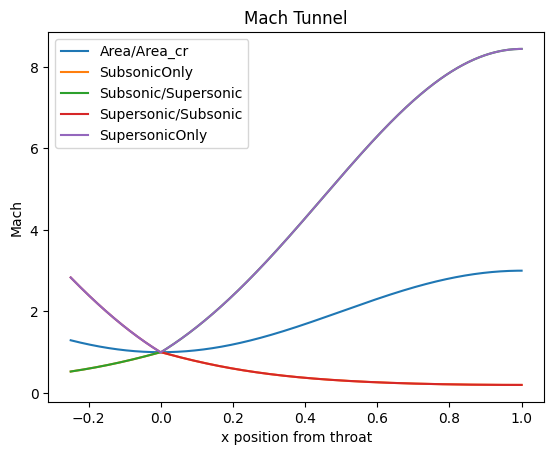

In [45]:
def CheckValues(dictionary:dict,dictionary_name:str):
  pd.DataFrame.from_dict(dictionary).to_csv(f'{dictionary_name}.csv')
  display(pd.DataFrame.from_dict(dictionary))
  return None
def Plot4DifferentSolutions(dictionary:dict,dictionary_name:str):
  situations = list(dictionary.keys())
  for i in situations:
    plt.plot(np.linspace(-0.25,1,1000),dictionary[i],label=i)
    plt.title(i)
    plt.xlabel('x position from throat')
    plt.ylabel(dictionary_name)
    plt.show()
  return None
def PlotAllSolutions(dictionary:dict,dictionary_name:str):
  situations = list(dictionary.keys())
  for i in situations:
    plt.plot(np.linspace(-0.25,1,1000),dictionary[i],label=i)
    plt.title('Mach Tunnel')
    plt.xlabel('x position from throat')
    plt.ylabel(dictionary_name)
    plt.legend()
  plt.savefig(f'{dictionary_name}.png')
  plt.show()
PlotAllSolutions(mach_values,'Mach')
# Plot4DifferentSolutions(mach_values,'Mach')
# CheckValues(mach_values,'Mach')

### Question 2
To find the stagnation pressure ratio as a function of mach, I used the following equation:
$$\frac{P_0}{P} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{\gamma-1}$$
$$\Rightarrow \frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$
The extra 2 functions are for grading purposes and just uncomment them to run

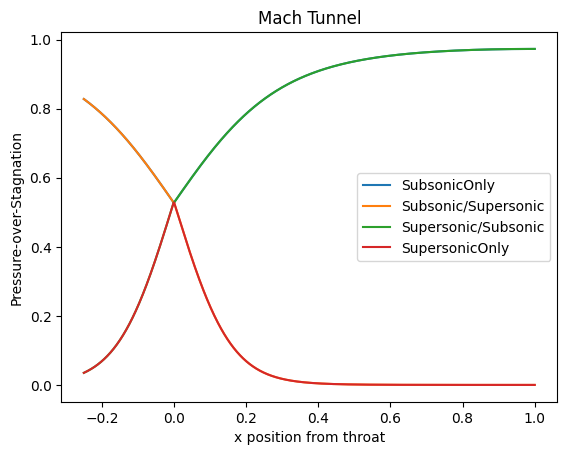

In [46]:
pressure_over_stagnation_function = lambda Mach_number: (1+.2*Mach_number**2)**(1.4/-0.4)
pressure_over_stagnation = {
  'SubsonicOnly':[pressure_over_stagnation_function(m) for m in mach_values['SubsonicOnly']],
  'Subsonic/Supersonic':[pressure_over_stagnation_function(m) for m in mach_values['Subsonic/Supersonic']],
  'Supersonic/Subsonic':[pressure_over_stagnation_function(m) for m in mach_values['Supersonic/Subsonic']],
  'SupersonicOnly':[pressure_over_stagnation_function(m) for m in mach_values['SupersonicOnly']]
}
PlotAllSolutions(pressure_over_stagnation,'Pressure-over-Stagnation')
# Plot4DifferentSolutions(pressure_over_stagnation,'Pressure-over-Stagnation')
# CheckValues(pressure_over_stagnation,'Pressure-over-Stagnation')

### Questions 3 through 12
No computation, just outputing values for the questions since all the values are stored in the dictionarys

In [54]:
displayVariable('3)M_{x=1}',mach_values['SubsonicOnly'][-1])
displayVariable('4)\\frac{P}{P_0}|_{x=1}',pressure_over_stagnation['SubsonicOnly'][-1])
displayVariable('5)M_{x=1}',mach_values['SupersonicOnly'][-1])
displayVariable('6)\\frac{P}{P_0}|_{x=1}',pressure_over_stagnation['SupersonicOnly'][-1])
displayVariable('7)M_{x=0}',mach_values['SupersonicOnly'][200])
displayVariable('8)\\frac{\\sigma}{\\sigma_{cr}}',mach_values['Area/Area_cr'][200])
displayVariable('9)M_{x=-0.25}',mach_values['SubsonicOnly'][0])
displayVariable('10)\\frac{P}{P_0}|_{x=-0.25}',pressure_over_stagnation['SubsonicOnly'][0])
displayVariable('11)M_{x=-0.25}',mach_values['SupersonicOnly'][0])
displayVariable('12)\\frac{P}{P_0}|_{x=-0.25}',pressure_over_stagnation['SupersonicOnly'][0])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Question 13
Starting from the isentropic pressure ratio equation we can solve for mach:
$$\frac{P}{P_0} = \left(1+\frac{\gamma-1}{2}M^2\right)^\frac{\gamma}{1-\gamma}$$
$$\left(\frac{P}{P_0}\right)^\frac{1-\gamma}{\gamma}-1= \frac{\gamma-1}{2}M^2$$
$$\frac{2\left(\frac{P}{P_0}\right)^\frac{1-\gamma}{\gamma}-2}{\gamma-1} = M^2$$
$$\therefore M = \sqrt{\frac{2\left(\frac{P}{P_0}\right)^\frac{1-\gamma}{\gamma}-2}{\gamma-1}}$$

In [55]:
MachFromPressureRatio = lambda pressure_ratio: np.sqrt((2*pressure_ratio**(-.4/1.4)-2)/.4)
displayVariable('M_{exit}',MachFromPressureRatio(0.99))

<IPython.core.display.Math object>